# Предсказание стоимости жилья

В проекте нам необходимо обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных требуется предсказать медианную стоимость дома в жилом массиве. Обучим модель и проверим её качество на тестовой выборке. Для оценки качества модели используем метрики RMSE, MAE и R2.

Данные, которые мы будем анализировать, были собраны в рамках переписи населения в США. Каждая строка содержит агрегированную статистику о жилом массиве. Жилой массив — минимальная географическая единица с населением от 600 до 3000 человек в зависимости от штата. Одна строка в данных содержит статистику в среднем о 1425.5 обитателях жилого массива.

## Загрузка и ознакомление с данными

In [1]:
# Нам предстоит решить задачу регрессии. Импортируем необходимые библиотеки.
import pandas as pd 
import numpy as np

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator
        
RANDOM_SEED = 12345

In [2]:
# Инициализируем локальную Spark-сессию
spark = SparkSession.builder \
                    .master("local") \
                    .appName("House - price prediction") \
                    .getOrCreate()

In [3]:
# Прочитаем содержимое файла с данными
df = spark.read.load('/datasets/housing.csv', format="csv", sep=",", inferSchema=True, header="true")

In [4]:
# Выведим типы данных колонок датасета
df.printSchema()
df.show(5)

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR B

В колонках датасета содержатся следующие данные:

- `longitude` — широта;
- `latitude` — долгота;
- `housing_median_age` — медианный возраст жителей жилого массива;
- `total_rooms` — общее количество комнат в домах жилого массива;
- `total_bedrooms` — общее количество спален в домах жилого массива;
- `population` — количество человек, которые проживают в жилом массиве;
- `households` — количество домовладений в жилом массиве;
- `median_income` — медианный доход жителей жилого массива;
- `median_house_value` — медианная стоимость дома в жилом массиве;
- `ocean_proximity` — близость к океану.

Во всех колонках хранятся количественные данные, кроме одной — `ocean_proximity`. Она хранит категориальные значения.

## Подготовка данных

### Обработка пропусков

In [5]:
# Исследуем данные на наличие пропусков
dict_null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
dict_null

{'longitude': 0,
 'latitude': 0,
 'housing_median_age': 0,
 'total_rooms': 0,
 'total_bedrooms': 207,
 'population': 0,
 'households': 0,
 'median_income': 0,
 'median_house_value': 0,
 'ocean_proximity': 0}

array([[<AxesSubplot:title={'center':'bedroom_index'}>]], dtype=object)

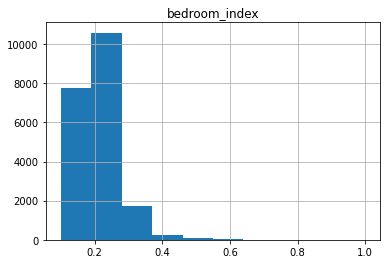

In [6]:
# Для заполнения пропусков количества спален определим, как оно связано с общим количеством комнат
df = df.withColumn('bedroom_index', F.col('total_bedrooms')/F.col('total_rooms'))
df.select('bedroom_index').toPandas().hist()

In [7]:
mean_bedroom_index = df.select('bedroom_index').toPandas().mean()[0]
mean_bedroom_index

0.21303883048085132

In [8]:
# Заполним пропуски средним значением признака для локаций с определённым количеством комнат
# создаём объект оконной функции
window = Window().partitionBy(['total_rooms'])
# заполним пропуски
df = df.withColumn('total_bedrooms_mean', F.round(F.mean('total_bedrooms').over(window)))
df = df.withColumn('total_bedrooms', F.coalesce('total_bedrooms', 'total_bedrooms_mean'))

In [9]:
# Проверим результат
dict_null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
dict_null

{'longitude': 0,
 'latitude': 0,
 'housing_median_age': 0,
 'total_rooms': 0,
 'total_bedrooms': 15,
 'population': 0,
 'households': 0,
 'median_income': 0,
 'median_house_value': 0,
 'ocean_proximity': 0,
 'bedroom_index': 207,
 'total_bedrooms_mean': 15}

In [10]:
# Оставшиеся пропуски заполним по среднему значению отношения числа спален к общему числу комнат
# заполним пропуски
df = df.withColumn('total_bedrooms_by_index', F.round(mean_bedroom_index*F.col('total_rooms')))
df = df.withColumn('total_bedrooms', F.coalesce('total_bedrooms', 'total_bedrooms_by_index'))

In [11]:
df = df.select(['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
                'households', 'median_income', 'median_house_value', 'ocean_proximity'])

In [12]:
# Проверим результат
dict_null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
dict_null

{'longitude': 0,
 'latitude': 0,
 'housing_median_age': 0,
 'total_rooms': 0,
 'total_bedrooms': 0,
 'population': 0,
 'households': 0,
 'median_income': 0,
 'median_house_value': 0,
 'ocean_proximity': 0}

Как видим, пропусков нет.

### Преобразование категориальных признаков

In [13]:
# Разделим датасет на выборки
train_data, test_data = df.randomSplit([.8,.2], seed=RANDOM_SEED)
print(train_data.count(), test_data.count())

16483 4157


In [14]:
# Создадим списки столбцов
categorical_cols = ['ocean_proximity']
numerical_cols  = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
                   'households', 'median_income']
target = 'median_house_value' 

In [15]:
# Выполним кодирование категориального признака
# В первую очередь трансформируем категориальные признаки с помощью трансформера StringIndexer.
# Он переводит текстовые категории в числовое представление, так как большинство ML-алгоритмов 
# работает с числовыми данными. Трансформер на вход принимает названия колонок, которые нужно трансформировать,
# и список названий новых колонок.
indexer = StringIndexer(inputCols=categorical_cols, 
                        outputCols=[c+'_idx' for c in categorical_cols],
                        handleInvalid = 'keep')
indexer_transformer = indexer.fit(train_data)
train_data = indexer_transformer.transform(train_data)
cols = [c for c in train_data.columns for i in categorical_cols if (c.startswith(i))]
train_data.select(cols).show(3)

+---------------+-------------------+
|ocean_proximity|ocean_proximity_idx|
+---------------+-------------------+
|     NEAR OCEAN|                2.0|
|         INLAND|                1.0|
|      <1H OCEAN|                0.0|
+---------------+-------------------+
only showing top 3 rows



In [16]:
# То же проделаем и с тестовыми данными
test_data = indexer_transformer.transform(test_data)
cols = [c for c in test_data.columns for i in categorical_cols if (c.startswith(i))]
test_data.select(cols).show(3)

+---------------+-------------------+
|ocean_proximity|ocean_proximity_idx|
+---------------+-------------------+
|       NEAR BAY|                3.0|
|         INLAND|                1.0|
|         INLAND|                1.0|
+---------------+-------------------+
only showing top 3 rows



In [17]:
# Теперь выполним OHE-кодирование категориальных признаков
encoder = OneHotEncoder(inputCols=[c+'_idx' for c in categorical_cols],
                        outputCols=[c+'_ohe' for c in categorical_cols])
encoder_transformer = encoder.fit(train_data)
train_data = encoder_transformer.transform(train_data)
cols = [c for c in train_data.columns for i in categorical_cols if (c.startswith(i))]
train_data.select(cols).show(3)

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|     NEAR OCEAN|                2.0|      (5,[2],[1.0])|
|         INLAND|                1.0|      (5,[1],[1.0])|
|      <1H OCEAN|                0.0|      (5,[0],[1.0])|
+---------------+-------------------+-------------------+
only showing top 3 rows



In [18]:
# То же проделаем и с тестовыми данными
test_data = encoder_transformer.transform(test_data)
cols = [c for c in test_data.columns for i in categorical_cols if (c.startswith(i))]
test_data.select(cols).show(3)

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|       NEAR BAY|                3.0|      (5,[3],[1.0])|
|         INLAND|                1.0|      (5,[1],[1.0])|
|         INLAND|                1.0|      (5,[1],[1.0])|
+---------------+-------------------+-------------------+
only showing top 3 rows



У нас всего один категориальный признак, поэтому применять VectorAssembler нет необходимости. Для универсальности кода на случай, если в данных появится более одного категориального признака, выполним следующий шаг.

In [19]:
# Объединеним признаки в один вектор, с которым ML-алгоритм умеет работать
categorical_assembler = \
        VectorAssembler(inputCols=[c+'_ohe' for c in categorical_cols],
                                        outputCol='categorical_features')
train_data = categorical_assembler.transform(train_data)
test_data = categorical_assembler.transform(test_data)

In [20]:
train_data.show(3)
test_data.show(3)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-------------------+-------------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|categorical_features|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-------------------+-------------------+--------------------+
|  -124.09|   40.87|              44.0|      692.0|         206.0|     398.0|     211.0|       1.1576|           87500.0|     NEAR OCEAN|                2.0|      (5,[2],[1.0])|       (5,[2],[1.0])|
|  -123.41|   40.61|              17.0|      769.0|         205.0|     301.0|     126.0|       1.7875|           55000.0|         INLAND|                1.0|      (5,[1],[1.0])|       (5,[1],[1.0])|
|  -1

### Преобразование числовых признаков

In [21]:
# Объединеним признаки в один вектор, с которым ML-алгоритм умеет работать
numerical_assembler = VectorAssembler(inputCols=numerical_cols, outputCol='numerical_features')
train_data = numerical_assembler.transform(train_data)
test_data = numerical_assembler.transform(test_data)

In [22]:
# Чтобы сильные выбросы не смещали предсказания модели, выполним масштабирование
standardScaler = StandardScaler(inputCol='numerical_features', outputCol="numerical_features_scaled")
standardScaler_transformer = standardScaler.fit(train_data)

In [23]:
train_data = standardScaler_transformer.transform(train_data)
test_data = standardScaler_transformer.transform(test_data)

In [24]:
train_data.show(3)
test_data.show(3)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-------------------+-------------------+--------------------+--------------------+-------------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|categorical_features|  numerical_features|numerical_features_scaled|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-------------------+-------------------+--------------------+--------------------+-------------------------+
|  -124.09|   40.87|              44.0|      692.0|         206.0|     398.0|     211.0|       1.1576|           87500.0|     NEAR OCEAN|                2.0|      (5,[2],[1.0])|       (5,[2],[1.0])|[-124.09,40.87,44...|     [-61.967341289012...|
|  -123.41|   40

### Сборка трансформированных категорийных и числовых признаков

In [25]:
all_features = ['categorical_features','numerical_features_scaled']

final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol='features') 
train_data = final_assembler.transform(train_data)
test_data = final_assembler.transform(test_data)

In [26]:
train_data.select(all_features+['features']).show(3) 
test_data.select(all_features+['features']).show(3)

+--------------------+-------------------------+--------------------+
|categorical_features|numerical_features_scaled|            features|
+--------------------+-------------------------+--------------------+
|       (5,[2],[1.0])|     [-61.967341289012...|[0.0,0.0,1.0,0.0,...|
|       (5,[1],[1.0])|     [-61.627766850487...|[0.0,1.0,0.0,0.0,...|
|       (5,[0],[1.0])|     [-61.213286285818...|[1.0,0.0,0.0,0.0,...|
+--------------------+-------------------------+--------------------+
only showing top 3 rows

+--------------------+-------------------------+--------------------+
|categorical_features|numerical_features_scaled|            features|
+--------------------+-------------------------+--------------------+
|       (5,[3],[1.0])|     [-61.038505324812...|[0.0,0.0,0.0,1.0,...|
|       (5,[1],[1.0])|     [-59.415539258334...|[0.0,1.0,0.0,0.0,...|
|       (5,[1],[1.0])|     [-59.395564291362...|[0.0,1.0,0.0,0.0,...|
+--------------------+-------------------------+-----------------

## Обучение моделей

Построим две модели линейной регрессии на разных наборах данных:
- используя все данные из файла,
- используя только числовые переменные, исключив категориальные.

Для построения модели используем оценщик LinearRegression из библиотеки MLlib.

In [27]:
# Обучим модель на всех данных
lr = LinearRegression(labelCol=target, featuresCol='features')

model = lr.fit(train_data) 

23/06/12 10:42:17 WARN Instrumentation: [c4c5bbd3] regParam is zero, which might cause numerical instability and overfitting.
23/06/12 10:42:18 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/06/12 10:42:18 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/06/12 10:42:26 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/06/12 10:42:26 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
23/06/12 10:42:26 WARN Instrumentation: [c4c5bbd3] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [28]:
# Вычислим предсказания модели, обученной на всех данных
predictions = model.transform(test_data)

predictedLabes = predictions.select(target, 'prediction')
predictedLabes.show(5) 

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           72000.0|199527.13218147447|
|           33200.0| 69004.23548728321|
|           87000.0|152199.96239089966|
|          500001.0| 460879.2899010144|
|          175900.0|159364.14040651126|
+------------------+------------------+
only showing top 5 rows



In [29]:
# Обучим модель на числовых данных
lr_numeric = LinearRegression(labelCol=target, featuresCol='numerical_features_scaled')

model_numeric = lr_numeric.fit(train_data) 

23/06/12 10:42:43 WARN Instrumentation: [241c3b19] regParam is zero, which might cause numerical instability and overfitting.


In [30]:
# Вычислим предсказания модели, обученной только на числовых данных
predictions_numeric = model_numeric.transform(test_data)

predictedLabes_numeric = predictions_numeric.select(target, 'prediction')
predictedLabes_numeric.show(5) 

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           72000.0| 197695.8336079321|
|           33200.0| 89380.27191233868|
|           87000.0|172136.00437851343|
|          500001.0|456903.00609040074|
|          175900.0|155340.94884492597|
+------------------+------------------+
only showing top 5 rows



Сравним результаты работы линейной регрессии на двух наборах данных по метрикам RMSE, MAE и R2.

In [31]:
# Создадим оценщик
evaluator = RegressionEvaluator()
evaluator.setPredictionCol('prediction')
evaluator.setLabelCol('median_house_value')

RegressionEvaluator_cacc80363858

In [32]:
# Оценим качество модели, обученой на всех данных
print('RMSE:', evaluator.evaluate(predictedLabes, {evaluator.metricName: 'rmse'}))
print('R2:', evaluator.evaluate(predictedLabes, {evaluator.metricName: 'r2'}))
print('MAE:', evaluator.evaluate(predictedLabes, {evaluator.metricName: 'mae'}))

RMSE: 68844.79698861134


R2: 0.6453692775773534


MAE: 49507.76763783298


In [33]:
# Оценим качество модели, обученой только на числовых данных
print('RMSE:', evaluator.evaluate(predictedLabes_numeric, {evaluator.metricName: 'rmse'}))
print('R2:', evaluator.evaluate(predictedLabes_numeric, {evaluator.metricName: 'r2'}))
print('MAE:', evaluator.evaluate(predictedLabes_numeric, {evaluator.metricName: 'mae'}))

RMSE: 69614.31955212049


R2: 0.6373970988922806


MAE: 50418.61421523291


## Анализ результатов

In [34]:
# Посмотрим, какие значения принимает целевой признак в выборке
df.select('median_house_value').describe().toPandas()

,summary,median_house_value
0,count,20640
1,mean,206855.81690891474
2,stddev,115395.61587441359
3,min,14999.0
4,max,500001.0


In [35]:
# Завершим Spark-сессию, чтоб освободить ресурсы кластера
spark.stop()

Полученные модели показали приблизительно одинаковые результаты с приблизительно в 2 раза более точным предсказанием по отношению к простому среднему значению. Для улучшения качества предсказания в дальнейшем можно выполнить подбор гиперпараметров моделей, рассмотреть другие модели. 